In [33]:
'''
import modules
'''
import pandas as pd
import numpy as np
import lightgbm as lgb
from datetime import datetime
import warnings
import gc
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [3]:
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

# 2016 Register to Apply(Boosted Tree)

In [56]:
'''
import data
'''
df_raw = pd.read_excel('./Data_Processed_All_Contractors_Characteristics.xlsx',sheet=1)
df_2016 = df_raw.loc[df_raw['year'] == 2016]
df_2016_xy = df_2016.iloc[:,:57].drop(['Dealer ID','year','JS 17.Column3','JS 18.Column3','JS 19.Column3','NON USER 17.Column3','NON USER 18.Column3','Velocity 17.Column3','centurty 18.Column3','Gibson 18.Column3','employeebucket-NA','employeebucket-4~8','employeebucket-<4',
       'employeebucket->8'],axis=1)

In [57]:
df_2016_xy.dropna(inplace=True)
# encode_numeric_range(df_2016_xy,'No. of Employees',0,1)

In [58]:
'''
clarify target and x variables (features and categorical features)
'''
train_df = df_2016_xy.loc[df_2016_xy['train_test'] == 1].drop('train_test',axis = 1)
test_df = df_2016_xy.loc[df_2016_xy['train_test'] == 0].drop('train_test',axis = 1)
x_train = train_df.iloc[:,:41]
y_train = train_df['applied 2016']
x_test = test_df.iloc[:,:41]
y_test = test_df['applied 2016']
features = [c for c in df_2016_xy.columns if c not in ['applied 2016','train_test']]
categorical_feats = features

In [59]:
'''
set one function with different parameters to do parameters optimization
'''
def lgb_cv(num_leaves,
           min_data_in_leaf,
           max_depth,
           feature_fraction,
           bagging_fraction,
           lambda_l1,
          threshold):
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(x_train.shape[0])
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(x_train.iloc[trn_idx][features],
                               label=y_train.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(x_train.iloc[val_idx][features],
                               label=y_train.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )
        param = {
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'binary',
            'max_depth': int(max_depth),
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,
            "bagging_fraction": bagging_fraction ,
            "bagging_seed": 11,
            "lambda_l1": lambda_l1,
            "verbosity": -1
        }
    
        clf = lgb.train(param,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 50)
        
        oof[val_idx] = clf.predict(x_train.iloc[val_idx][features],
                                   num_iteration=clf.best_iteration)
        del clf, trn_idx, val_idx
        gc.collect()
    
    for i in range(x_train.shape[0]):
        if oof[i] >= threshold:
            oof[i] = 1
        else:
            oof[i] = 0

    return accuracy_score(oof, y_train.values)

In [60]:
'''
use bayesian optimization to find the optimal parameters in ranges
'''
LGB_BO = BayesianOptimization(lgb_cv, {
    'num_leaves': (5, 130),
    'min_data_in_leaf': (10, 150),
    'max_depth': (4, 10),
    'feature_fraction': (1,1),
    'bagging_fraction': (1,1),
    'lambda_l1': (0, 6),
    'threshold':(0.5,0.5),
    })

In [61]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)

|   iter    |  target   | baggin... | featur... | lambda_l1 | max_depth | min_da... | num_le... | threshold |
-------------------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.626499	valid_1's binary_logloss: 0.687515
fold n°1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.633861	valid_1's binary_logloss: 0.673045
fold n°2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.668795	valid_1's binary_logloss: 0.686622
fold n°3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.575322	valid_1's binary_logloss: 0.652521
fold n°4
Training until validation scores don't impr

fold n°2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.687354	valid_1's binary_logloss: 0.693135
fold n°3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.627616	valid_1's binary_logloss: 0.676788
fold n°4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.660848	valid_1's binary_logloss: 0.683263
|  8        |  0.545    |  1.0      |  1.0      |  0.08001  |  4.249    |  71.34    |  70.72    |  0.5      |
fold n°0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.633732	valid_1's binary_logloss: 0.680734
fold n°1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.631111	valid_1's binary

fold n°0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.650967	valid_1's binary_logloss: 0.688731
fold n°1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.565512	valid_1's binary_logloss: 0.677154
fold n°2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.636047	valid_1's binary_logloss: 0.681586
fold n°3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.530676	valid_1's binary_logloss: 0.661783
fold n°4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.684184	valid_1's binary_logloss: 0.692797
|  16       |  0.5544   |  1.0      |  1.0      |  0.02095  |  9.979    |  10.0     |  58.22 

In [62]:
'''
set parameters
'''
param = {
            'num_leaves': 60,
            'min_data_in_leaf': 17, 
            'objective':'binary',
            'max_depth': 4,
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": 1,
            "bagging_freq": 1,
            "bagging_fraction": 1,
            "bagging_seed": 11,
            "lambda_l1": 0.09404,
            "verbosity": -1
        }

In [63]:
'''
run boosted tree
'''
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features],
                           label=y_train.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(x_train.iloc[val_idx][features],
                           label=y_train.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(x_test[features], num_iteration=clf.best_iteration) / folds.n_splits

pred_0_1 = [0]*len(predictions)
for i in range(x_train.shape[0]):
        if oof[i] >= 0.5:
            oof[i] = 1
        else:
            oof[i] = 0
for i in range(len(predictions)):
        if predictions[i] >= 0.5:
            pred_0_1[i] = 1
        else:
            pred_0_1[i] = 0
print("CV score: {:<8.5f}".format(accuracy_score(oof, y_train.values)))
print("Test Accuracy:{:<8.5f}".format(accuracy_score(pred_0_1, y_test.values)))

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.650738	valid_1's binary_logloss: 0.685054
fold n°1
Training until validation scores don't improve for 200 rounds.


C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.626112	valid_1's binary_logloss: 0.669578
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.669244	valid_1's binary_logloss: 0.686546
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.639597	valid_1's binary_logloss: 0.662872
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.646779	valid_1's binary_logloss: 0.685413
CV score: 0.54156 
Test Accuracy:0.61168 


In [64]:
matrix = confusion_matrix(y_test.values, pred_0_1, labels=None, sample_weight=None)

In [65]:
def metrix_matrix(matrix):
    df_matrix=pd.DataFrame(matrix,columns=['pred_0','pred_1'],index=['actual_0','actual_1'])
    tn, fp, fn, tp=matrix.ravel()
    acc=(tp+tn)/(tp+tn+fp+fn)
    ppv=tp/(tp+fp)
    npv=tn/(tn+fn)
    tpr=tp/(tp+fn)
    tnr=tn/(tn+fp)
    summary_matrix=[acc,ppv,npv,tpr,tnr]
    df_summary=pd.DataFrame(summary_matrix,columns=['Value'],index=['Accuracy','PPV','NPV','Sensitivity','Specificity'])
    return df_matrix,df_summary

In [66]:
df_matrix,df_summary = metrix_matrix(matrix)

In [67]:
df_matrix

,pred_0,pred_1
actual_0,60,72
actual_1,41,118


In [68]:
df_summary

,Value
Accuracy,0.611684
PPV,0.621053
NPV,0.594059
Sensitivity,0.742138
Specificity,0.454545


In [69]:
contractor_id = df_2016.loc[(df_2016['train_test'] == 0)&(df_2016['No. of Employees'].isnull()==False),'Dealer ID'].values
actual = y_test
predicted_prob = np.array(predictions)
predicted= pred_0_1

In [70]:
df_result=pd.DataFrame()
df_result["contractor_id"]=contractor_id
df_result["actual"]=actual
df_result["predicted"]=predicted
df_result["predicted_prob"]=predicted_prob

In [71]:
def TP(columna,columnb):
    if columna==1 and columnb==1:
        x=1
    else:
        x=0
    return x

In [72]:
df_result=df_result.sort_values(by=["predicted_prob"],ascending=False)
df_result["Actual_Positive"]=df_result.apply(lambda x: TP(x["actual"],x["predicted"]),axis=1)
df_result["Cumulative_Positives"]=df_result["Actual_Positive"].cumsum()
total_positives=df_result["Actual_Positive"].sum()
df_result["Cumulative_Positives_percent"]=df_result["Cumulative_Positives"]/total_positives
df_result["Cumulative_Count"]=df_result["contractor_id"].expanding().count()/df_result["contractor_id"].count()

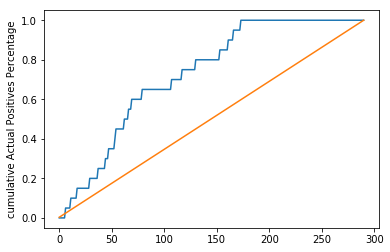

In [73]:
plt.plot(df_result["Cumulative_Positives_percent"].values.tolist())
plt.plot(df_result["Cumulative_Count"].values.tolist())
plt.ylabel('cumulative Actual Positives Percentage')

plt.show()

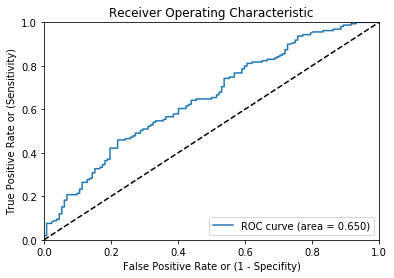

In [74]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(actual, predicted_prob,1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# 2017 Register to Apply (Boosted Tree)

In [77]:
df_2017 = df_raw.loc[df_raw['year'] == 2017]
df_2017_xy = df_2017.iloc[:,:58].drop(['Dealer ID','year','applied 2016','JS 16.Column3','JS 18.Column3','JS 19.Column3','NON USER 16.Column3','NON USER 18.Column3','centurty 18.Column3','Gibson 18.Column3','Hitting Potential 16.Column3','employeebucket-NA','employeebucket-4~8','employeebucket-<4',
       'employeebucket->8'],axis=1)
df_2017_xy.dropna(inplace=True)
# encode_numeric_range(df_2016_xy,'No. of Employees',0,1)
train_df = df_2017_xy.loc[df_2017_xy['train_test'] == 1].drop('train_test',axis = 1)
test_df = df_2017_xy.loc[df_2017_xy['train_test'] == 0].drop('train_test',axis = 1)
x_train = train_df.iloc[:,:41]
y_train = train_df['applied 2017']
x_test = test_df.iloc[:,:41]
y_test = test_df['applied 2017']
features = [c for c in df_2017_xy.columns if c not in ['applied 2017','train_test']]
categorical_feats = features

In [78]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)

|   iter    |  target   | baggin... | featur... | lambda_l1 | max_depth | min_da... | num_le... | threshold |
-------------------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.672905	valid_1's binary_logloss: 0.697239
fold n°1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.631594	valid_1's binary_logloss: 0.672805
fold n°2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.646274	valid_1's binary_logloss: 0.683449
fold n°3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.666751	valid_1's binary_logloss: 0.687169
fold n°4
Training until validation scores don't impro

fold n°3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.654296	valid_1's binary_logloss: 0.682676
fold n°4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.691827	valid_1's binary_logloss: 0.693608
|  32       |  0.5366   |  1.0      |  1.0      |  0.0      |  4.0      |  150.0    |  44.94    |  0.5      |
fold n°0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.682998	valid_1's binary_logloss: 0.697323
fold n°1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.626531	valid_1's binary_logloss: 0.669394
fold n°2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.686079	valid_1's binary

fold n°0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.676098	valid_1's binary_logloss: 0.697956
fold n°1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.641184	valid_1's binary_logloss: 0.677237
fold n°2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.663743	valid_1's binary_logloss: 0.689063
fold n°3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.65195	valid_1's binary_logloss: 0.686492
fold n°4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.681203	valid_1's binary_logloss: 0.69191
|  40       |  0.5315   |  1.0      |  1.0      |  5.865    |  8.705    |  10.63    |  54.44  

In [79]:
'''
set parameters
'''
param = {
            'num_leaves': 24,
            'min_data_in_leaf': 133, 
            'objective':'binary',
            'max_depth': 4,
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": 1,
            "bagging_freq": 1,
            "bagging_fraction": 1,
            "bagging_seed": 11,
            "lambda_l1": 0.1197,
            "verbosity": -1
        }

In [81]:
'''
run boosted tree
'''
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features],
                           label=y_train.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(x_train.iloc[val_idx][features],
                           label=y_train.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(x_test[features], num_iteration=clf.best_iteration) / folds.n_splits

pred_0_1 = [0]*len(predictions)
for i in range(x_train.shape[0]):
        if oof[i] >= 0.5:
            oof[i] = 1
        else:
            oof[i] = 0
for i in range(len(predictions)):
        if predictions[i] >= 0.5:
            pred_0_1[i] = 1
        else:
            pred_0_1[i] = 0
print("CV score: {:<8.5f}".format(accuracy_score(oof, y_train.values)))
print("Test Accuracy:{:<8.5f}".format(accuracy_score(pred_0_1, y_test.values)))

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.683563	valid_1's binary_logloss: 0.69833
fold n°1
Training until validation scores don't improve for 200 rounds.


C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[500]	training's binary_logloss: 0.624102	valid_1's binary_logloss: 0.673143
[1000]	training's binary_logloss: 0.600617	valid_1's binary_logloss: 0.671142
Early stopping, best iteration is:
[1018]	training's binary_logloss: 0.599858	valid_1's binary_logloss: 0.670509
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.692227	valid_1's binary_logloss: 0.692773
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.677497	valid_1's binary_logloss: 0.689558
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.691833	valid_1's binary_logloss: 0.693605
CV score: 0.52541 
Test Accuracy:0.54878 


In [82]:
matrix = confusion_matrix(y_test.values, pred_0_1, labels=None, sample_weight=None)
df_matrix,df_summary = metrix_matrix(matrix)

In [83]:
df_matrix

,pred_0,pred_1
actual_0,64,61
actual_1,50,71


In [84]:
df_summary

,Value
Accuracy,0.548780
PPV,0.537879
NPV,0.561404
Sensitivity,0.586777
Specificity,0.512000


In [85]:
contractor_id = df_2017.loc[(df_2017['train_test'] == 0)&(df_2017['No. of Employees'].isnull()==False),'Dealer ID'].values
actual = y_test.values
predicted_prob = np.array(predictions)
predicted= pred_0_1

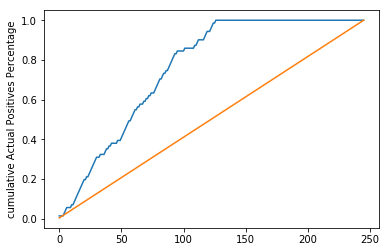

In [86]:
df_result=pd.DataFrame()
df_result["contractor_id"]=contractor_id
df_result["actual"]=actual
df_result["predicted"]=predicted
df_result["predicted_prob"]=predicted_prob
df_result=df_result.sort_values(by=["predicted_prob"],ascending=False)
df_result["Actual_Positive"]=df_result.apply(lambda x: TP(x["actual"],x["predicted"]),axis=1)
df_result["Cumulative_Positives"]=df_result["Actual_Positive"].cumsum()
total_positives=df_result["Actual_Positive"].sum()
df_result["Cumulative_Positives_percent"]=df_result["Cumulative_Positives"]/total_positives
df_result["Cumulative_Count"]=df_result["contractor_id"].expanding().count()/df_result["contractor_id"].count()
plt.plot(df_result["Cumulative_Positives_percent"].values.tolist())
plt.plot(df_result["Cumulative_Count"].values.tolist())
plt.ylabel('cumulative Actual Positives Percentage')

plt.show()

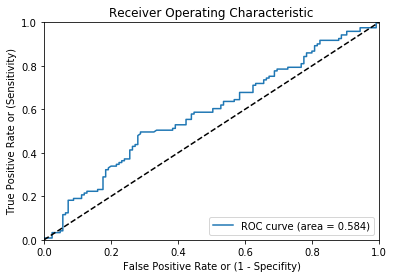

In [87]:
fpr, tpr, thresholds = roc_curve(actual, predicted_prob,1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Window 1 Year (Boosted Tree)

In [88]:
df_window_one_year = df_raw.loc[(df_raw['applied_in_window_12months_or_not'] != 'Not enough info')&(df_raw['No. of Employees'].isnull() == False)]
# encode_numeric_range(df_window_one_year,'No. of Employees',0,1)
x_train = df_window_one_year.loc[df_raw['train_test'] == 1].iloc[:,:56].drop(['Dealer ID','year','train_test','employeebucket-NA','employeebucket-4~8','employeebucket-<4',
       'employeebucket->8'],axis=1)
y_train = df_window_one_year.loc[df_raw['train_test'] == 1].iloc[:,73].astype(int)
x_test = df_window_one_year.loc[df_raw['train_test'] == 0].iloc[:,:56].drop(['Dealer ID','year','train_test','employeebucket-NA','employeebucket-4~8','employeebucket-<4',
       'employeebucket->8'],axis=1)
y_test = df_window_one_year.loc[df_raw['train_test'] == 0].iloc[:,73].astype(int)

In [89]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)

|   iter    |  target   | baggin... | featur... | lambda_l1 | max_depth | min_da... | num_le... | threshold |
-------------------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.638034	valid_1's binary_logloss: 0.644664
fold n°1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.625612	valid_1's binary_logloss: 0.649882
fold n°2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.622831	valid_1's binary_logloss: 0.66549
fold n°3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.619967	valid_1's binary_logloss: 0.631649
fold n°4
Training until validation scores don't impro

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.627495	valid_1's binary_logloss: 0.671345
fold n°3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.629037	valid_1's binary_logloss: 0.640113
fold n°4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.63532	valid_1's binary_logloss: 0.65342
|  54       |  0.6225   |  1.0      |  1.0      |  5.929    |  4.413    |  80.13    |  5.73     |  0.5      |
fold n°0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.644275	valid_1's binary_logloss: 0.650369
fold n°1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.619711	valid_1's binary_loglo

fold n°0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.642015	valid_1's binary_logloss: 0.645004
fold n°1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.613965	valid_1's binary_logloss: 0.649937
fold n°2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.62856	valid_1's binary_logloss: 0.666402
fold n°3
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.629491	valid_1's binary_logloss: 0.635349
fold n°4
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.623577	valid_1's binary_logloss: 0.647728
|  62       |  0.6341   |  1.0      |  1.0      |  5.706    |  4.124    |  37.08    |  22.

In [90]:
'''
set parameters
'''
param = {
            'num_leaves': 23,
            'min_data_in_leaf': 32, 
            'objective':'binary',
            'max_depth': 4,
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": 1,
            "bagging_freq": 1,
            "bagging_fraction": 1,
            "bagging_seed": 11,
            "lambda_l1": 5.988,
            "verbosity": -1
        }

In [91]:
'''
run boosted tree
'''
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features],
                           label=y_train.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(x_train.iloc[val_idx][features],
                           label=y_train.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(x_test[features], num_iteration=clf.best_iteration) / folds.n_splits

pred_0_1 = [0]*len(predictions)
for i in range(x_train.shape[0]):
        if oof[i] >= 0.5:
            oof[i] = 1
        else:
            oof[i] = 0
for i in range(len(predictions)):
        if predictions[i] >= 0.5:
            pred_0_1[i] = 1
        else:
            pred_0_1[i] = 0
print("CV score: {:<8.5f}".format(accuracy_score(oof, y_train.values)))
print("Test Accuracy:{:<8.5f}".format(accuracy_score(pred_0_1, y_test.values)))

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.639941	valid_1's binary_logloss: 0.645424
fold n°1
Training until validation scores don't improve for 200 rounds.


C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.614586	valid_1's binary_logloss: 0.650418
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.627923	valid_1's binary_logloss: 0.666648
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.617201	valid_1's binary_logloss: 0.635009
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.624156	valid_1's binary_logloss: 0.647208
CV score: 0.63406 
Test Accuracy:0.64436 


In [92]:
matrix = confusion_matrix(y_test.values, pred_0_1, labels=None, sample_weight=None)
df_matrix,df_summary = metrix_matrix(matrix)

In [93]:
df_matrix

,pred_0,pred_1
actual_0,22,268
actual_1,3,469


In [94]:
df_summary

,Value
Accuracy,0.644357
PPV,0.636364
NPV,0.880000
Sensitivity,0.993644
Specificity,0.075862


In [95]:
contractor_id = df_window_one_year.loc[(df_window_one_year['train_test'] == 0),'Dealer ID'].values
actual = y_test.values
predicted_prob = np.array(predictions)
predicted= pred_0_1

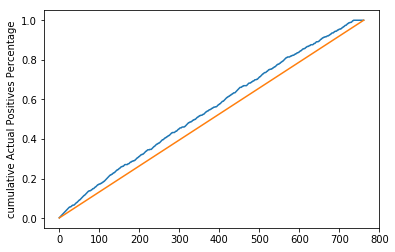

In [96]:
df_result=pd.DataFrame()
df_result["contractor_id"]=contractor_id
df_result["actual"]=actual
df_result["predicted"]=predicted
df_result["predicted_prob"]=predicted_prob
df_result=df_result.sort_values(by=["predicted_prob"],ascending=False)
df_result["Actual_Positive"]=df_result.apply(lambda x: TP(x["actual"],x["predicted"]),axis=1)
df_result["Cumulative_Positives"]=df_result["Actual_Positive"].cumsum()
total_positives=df_result["Actual_Positive"].sum()
df_result["Cumulative_Positives_percent"]=df_result["Cumulative_Positives"]/total_positives
df_result["Cumulative_Count"]=df_result["contractor_id"].expanding().count()/df_result["contractor_id"].count()
plt.plot(df_result["Cumulative_Positives_percent"].values.tolist())
plt.plot(df_result["Cumulative_Count"].values.tolist())
plt.ylabel('cumulative Actual Positives Percentage')

plt.show()

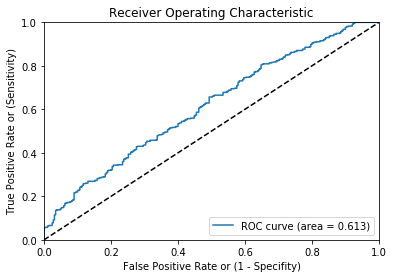

In [97]:
fpr, tpr, thresholds = roc_curve(actual, predicted_prob,1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")